# Dr LIM - Dimensionality reduction by Learning Invariant Mapping

- This paper (similar to TSNE) proposes an alternative method to achieve dimensionality reduction

In [25]:
from functools import reduce
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

from image_utilities import plot_images

## CNN used in the paper 

![CNN architecture](./images/cnn.png)

### Torch implementation 

#### Forward

In [2]:
class DrlimCNN(nn.Module):
    def __init__(self, n_lower_dim=2):
        super(DrlimCNN, self).__init__()
        
        # Layer 1:
        # n_input_channel = 1
        # n_output_channel = 15
        # Kernel Size = 5 for padding = 0, stride = 1
        k_size = 5
        in_channels = 1
        out_channels = 15 
        self.layer_1 = nn.Conv2d(in_channels, out_channels, k_size)
        
        # Layer 2: Subsampling - Maxpooling
        # Kernel Size = 15  for padding=0 and stride = 1
        k_size = 15
        self.max_pooling = nn.MaxPool2d(k_size, stride=1)
        
        # Layer 3: Conv layer
        # n_input_channel = 15
        # n_output_channel = 30
        # Kernel size = 10
        in_channels = 15
        out_channels = 30
        k_size = 10
        self.layer_3 = nn.Conv2d(in_channels, out_channels, k_size)
        
        # Layer 4: Fully connected
        self.output_layer = nn.Linear(30, n_lower_dim)
        
        # Output probs
        self.softmax = nn.Softmax(dim=1)
        
        # Relu
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Add relu on top of conv layer
        x = self.layer_1(x)
        x = self.relu(x)
        
        # Maxpool 
        x = self.max_pooling(x)
        
        # Another conv
        x = self.layer_3(x)
        
        # Get the size except for batch
        num_flat_features = reduce(lambda x, y: x * y, x.shape[1:])
        
        # Flatten
        x = x.reshape(1, num_flat_features)
        
        # Fully connected 
        x = self.output_layer(x)
        
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = DrlimCNN()

# Enable GPU
net.to(device)
net.cuda()

cuda:0


DrlimCNN(
  (layer_1): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
  (max_pooling): MaxPool2d(kernel_size=15, stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer_3): Conv2d(15, 30, kernel_size=(10, 10), stride=(1, 1))
  (output_layer): Linear(in_features=30, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
)

#### Backward

##### Define contrastive loss function

In [3]:
def contrastive_loss(output_1, output_2, 
            target_1, target_2):
    if target_1 == target_2:
        y = torch.zeros_like(output_1, requires_grad=True)
    else:
        y = torch.ones_like(output_1, requires_grad=True)
        
    distance = torch.norm(output_1 - output_2)
    ls = torch.pow(distance, 2)
    ld = torch.max(torch.zeros_like(output_1), distance)
    ld = torch.pow(ld, 2)
    
    loss = torch.mean((1 - y) * ls + y * ld)
    
    return loss

In [4]:
# Test Code
input_1 = torch.randn(1, 1, 28, 28)
input_2 = torch.randn(1, 1, 28, 28)

out_1 = net(input_1.cuda())
out_2 = net(input_2.cuda())
out_1 = out_1.requires_grad_(True)
out_2 = out_2.requires_grad_(True)

print("---------")
print(out_1.requires_grad)
print(out_2.requires_grad)
print("---------")

print("Before:")
print(net.output_layer.weight.grad)
loss = contrastive_loss(out_1, out_2,
                        0, 0)
print(loss)
loss.backward()
print("After:")
print(net.output_layer.weight.grad)

---------
True
True
---------
Before:
None
tensor(0.0411, device='cuda:0', grad_fn=<MeanBackward0>)
After:
tensor([[ 0.0339,  0.0260, -0.0190, -0.0276,  0.0170,  0.0058, -0.0760, -0.0288,
         -0.0230, -0.0130,  0.0396, -0.0040, -0.0219, -0.0394, -0.0045, -0.0224,
          0.0871,  0.0383, -0.0896,  0.0014, -0.0022, -0.0303, -0.0251, -0.0626,
          0.0040,  0.0215,  0.0654,  0.0364,  0.0791, -0.0229],
        [-0.0520, -0.0400,  0.0291,  0.0423, -0.0261, -0.0089,  0.1168,  0.0443,
          0.0354,  0.0200, -0.0608,  0.0061,  0.0337,  0.0605,  0.0070,  0.0343,
         -0.1338, -0.0588,  0.1376, -0.0021,  0.0034,  0.0466,  0.0385,  0.0962,
         -0.0062, -0.0331, -0.1005, -0.0559, -0.1215,  0.0351]],
       device='cuda:0')


## Load Data

In [5]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

## Train

In [6]:
n_epochs = 100
optimizer = optim.Adam(net.parameters(), lr=0.001)

all_data = []
all_target = []

for batch_idx, (data, target) in enumerate(train_loader):
    # Choose only either 5 or 10 number 
    filter_index = ((target == 4) | (target == 9))
    all_data += data[filter_index].numpy().tolist()
    all_target += target[filter_index].numpy().tolist()

for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(len(all_data) - 1): 
        data_1 = torch.tensor(all_data[i])
        data_1 = torch.unsqueeze(data_1, 0)
        target_1 = torch.tensor(all_target[i])
        
        data_2 = torch.tensor(all_data[i + 1])
        data_2 = torch.unsqueeze(data_2, 0)
        target_2 = torch.tensor(all_target[i + 1])
        
        optimizer.zero_grad()

        # Enable GPUs
        input_1, label_1 = data_1.to(device), target_1.to(device)
        input_2, label_2 = data_2.to(device), target_2.to(device)
        
        out_1 = net(input_1)
        out_2 = net(input_2)
        out_1 = out_1.requires_grad_(True)
        out_2 = out_2.requires_grad_(True)

        loss = contrastive_loss(out_1, out_2,
                                label_1, label_2)

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f\r' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print("")

print('Finished Training')

[1,  2000] loss: 0.017
[1,  4000] loss: 0.017
[1,  6000] loss: 0.017
[1,  8000] loss: 0.017
[1, 10000] loss: 0.018
[2,  2000] loss: 0.017
[2,  4000] loss: 0.017
[2,  6000] loss: 0.017
[2,  8000] loss: 0.017
[2, 10000] loss: 0.018
[3,  2000] loss: 0.017
[3,  4000] loss: 0.017
[3,  6000] loss: 0.017
[3,  8000] loss: 0.017
[3, 10000] loss: 0.018
[4,  2000] loss: 0.017
[4,  4000] loss: 0.017
[4,  6000] loss: 0.017
[4,  8000] loss: 0.017
[4, 10000] loss: 0.018
[5,  2000] loss: 0.017
[5,  4000] loss: 0.017
[5,  6000] loss: 0.017
[5,  8000] loss: 0.017
[5, 10000] loss: 0.018
[6,  2000] loss: 0.017
[6,  4000] loss: 0.017
[6,  6000] loss: 0.017
[6,  8000] loss: 0.017
[6, 10000] loss: 0.018
[7,  2000] loss: 0.017
[7,  4000] loss: 0.017
[7,  6000] loss: 0.017
[7,  8000] loss: 0.017
[7, 10000] loss: 0.018
[8,  2000] loss: 0.017
[8,  4000] loss: 0.017
[8,  6000] loss: 0.017
[8,  8000] loss: 0.017
[8, 10000] loss: 0.018
[9,  2000] loss: 0.017
[9,  4000] loss: 0.017
[9,  6000] loss: 0.017
[9,  8000] 

In [8]:
data_4 = []
target_4 = []

data_11 = []
target_11 = []
for batch_idx, (data, target) in enumerate(test_loader):
    # Choose only either 5 or 10 number 
    filter_index = (target == 4)
    data_4 += data[filter_index].numpy().tolist()
    target_4 += target[filter_index].numpy().tolist()
    
    filter_index = (target == 9)
    data_11 += data[filter_index].numpy().tolist()
    target_11 += target[filter_index].numpy().tolist()

In [22]:
# Manifold
data_manifold_4 = [] 
data_manifold_11 = [] 

for i in range(len(data_4)):
    input_4 = torch.tensor(data_4[i]).unsqueeze(0).to(device)
    out = net(input_4)
    out = out.clone()
    out = out.cpu().detach().numpy().squeeze()
    data_manifold_4.append(out)
    
data_manifold_4 = np.array(data_manifold_4)
    
for i in range(len(data_11)):
    input_11 = torch.tensor(data_11[i]).unsqueeze(0).to(device)
    out = net(input_11)
    out = out.clone()
    out = out.cpu().detach().numpy().squeeze()
    data_manifold_11.append(out)
    
data_manifold_11 = np.array(data_manifold_11)

In [27]:
data_11_x = data_manifold_11[:, 0]
data_11_y = data_manifold_11[:, 1]

data_4_x = data_manifold_4[:, 0]
data_4_y = data_manifold_4[:, 1]

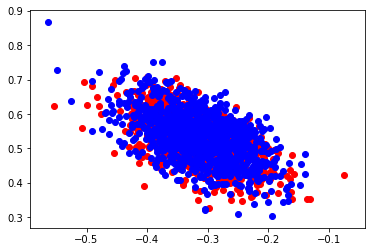

In [32]:
plt.scatter(data_11_x, data_11_y, color="r")
plt.scatter(data_4_x, data_4_y, color="b")
plt.show()